In [24]:
# keras supplied image generator
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2DTranspose, Conv2D, UpSampling2D, Reshape, Flatten, MaxPooling2D
from keras.optimizers import RMSprop
from IPython.display import Image, display
from itertools import repeat
import PIL
from datetime import datetime

import numpy as np

#the size for both the real and the fake data
partial_batch_size = 64
scale_up = 4

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

read_data_gen = datagen.flow_from_directory(os.getcwd()+'/training/', target_size=(64,64),batch_size=partial_batch_size)

def output_to_image(array):
    array = array*127.5+127.5
    i = array_to_img(array).resize((64*scale_up,64*scale_up), PIL.Image.ANTIALIAS)
    return i


Found 296 images belonging to 1 classes.


Generator is based off of `UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS` available [here](https://arxiv.org/abs/1511.06434)

In [25]:
def get_generator():
    m = Sequential()
    m.add(Dense((4*4*1024), input_shape=(100,), activation = 'relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Reshape((4,4,1024)))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(512,8, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(256,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(128,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(64,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Conv2DTranspose(3,5, activation = 'sigmoid', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    return m

generator_model = get_generator()
generator_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 16384)             1654784   
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
up_sampling2d_33 (UpSampling (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 8, 8, 512)         33554944  
_________________________________________________________________
up_sampling2d_34 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 16, 16, 256)       3277056   
_________________________________________________________________
up_sampling2d_35 (UpSampling (None, 32, 32, 256)       0         
__________

This network takes 100 random numbers and generates an eye from it (once it's been trained). 

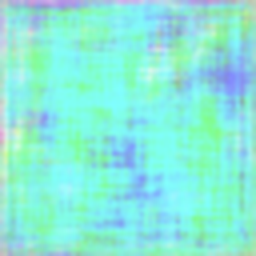

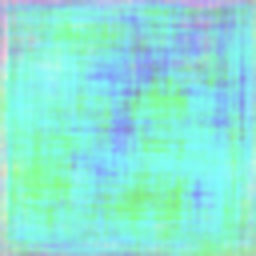

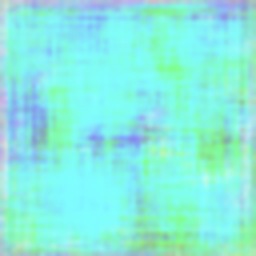

In [26]:
sample_in = np.random.uniform(-1, 1, (3,100))

sample_out = generator_model.predict(sample_in)

for a in sample_out:
    display(output_to_image(a))

For comparison, here are some real images:

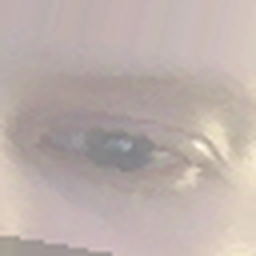

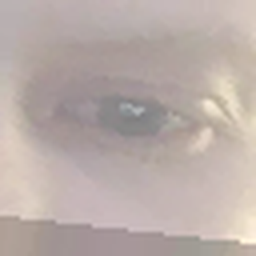

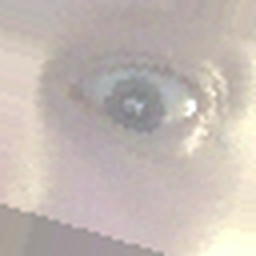

In [27]:

for eye in next(read_data_gen)[0][1:4]:
    display(output_to_image(eye))

For simplicity, we'll use a simple classifier from [Keras's blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [28]:
def get_descriminator():
    m = Sequential()
    m.add(Conv2D(32,3, input_shape=(64,64,3,), activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Conv2D(32,3, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Conv2D(64,3, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Flatten())
    m.add(Dense(1, activation = 'sigmoid'))
    return m

descriminator = get_descriminator()
descriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4096)              0         
__________

Finally we'll combine and compile the two models:

In [41]:
def compile(descriminator, generator):
    combined = Sequential()
    combined.add(generator)
    combined.add(descriminator)
    combined.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001))
    
    descriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001))
    generator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001))
    return combined, descriminator, generator

combined, descriminator, generator = compile(get_descriminator(), get_generator())
    
# not as exciting as it could be...
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_36 (Sequential)   (None, 64, 64, 3)         39515779  
_________________________________________________________________
sequential_35 (Sequential)   (None, 1)                 32737     
Total params: 39,548,516.0
Trainable params: 39,548,516.0
Non-trainable params: 0.0
_________________________________________________________________


Now all we have to do is train it.

Epoch 1/10
128/128 [==============================] - 1s - loss: 0.6931     
Epoch 2/10
128/128 [==============================] - 0s - loss: 0.6893     
Epoch 3/10
128/128 [==============================] - 0s - loss: 0.6858     
Epoch 4/10
128/128 [==============================] - 0s - loss: 0.6813     
Epoch 5/10
128/128 [==============================] - 0s - loss: 0.6749     
Epoch 6/10
128/128 [==============================] - 0s - loss: 0.6678     
Epoch 7/10
128/128 [==============================] - 0s - loss: 0.6584     
Epoch 8/10
128/128 [==============================] - 0s - loss: 0.6471     
Epoch 9/10
128/128 [==============================] - 0s - loss: 0.6338     
Epoch 10/10
128/128 [==============================] - 0s - loss: 0.6187     


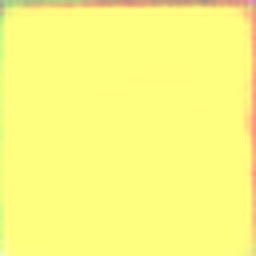

Step: 0, Descriminator: 0.606255, Combined: 0.774442
Step: 1, Descriminator: 0.803896, Combined: 0.458869
Step: 2, Descriminator: 0.800864, Combined: 0.447249
Step: 3, Descriminator: 0.798969, Combined: 0.441963


KeyboardInterrupt: 

In [42]:
def fit(steps = 10000):
    
    def gen_data():
        real = next(read_data_gen)[0]
        
        # if the number of real images isn't evenly divided by the target batch size, this will be different at the end
        actual_batch_size = len(real)
        
        fake_in = np.random.uniform(-1, 1, (actual_batch_size,100))
        fake = generator.predict(fake_in)
        
        x = np.concatenate((real,fake))
        y = np.ones([actual_batch_size*2,1])
        y[actual_batch_size:,:] = 0
        
        return x, y
    
    x,y = gen_data()
    descriminator.fit(x,y, epochs = 10)
    
    for step in range(steps):
        x, y = gen_data()
        
        d_err = descriminator.train_on_batch(x,y)
        
        fake_in = np.random.uniform(-1, 1, (partial_batch_size,100))
        y = np.ones([partial_batch_size,1])
        descriminator.trainable = False
        c_err = combined.train_on_batch(fake_in, y)
        descriminator.trainable = True
        
        sample = generator.predict(fake_in)[0]

        if step % 10 == 0:
            display(output_to_image(sample))
        print("%s: Step: %d, Descriminator: %f, Combined: %f"%(str(datetime.now()), step, d_err, c_err))
        
        
fit()
        